Script for modeling calcium diffusion in a rectangular tube with zero flux in the x-, y-, and z-directions. 
Compares output from analytical solution and MCell solution.

Last updated: 12/15/21 7:24PM

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob
import seaborn as sns
from scipy import stats

In [2]:
# GLOBAL CONSTANT
D = 2.20e-4     # Diffusion coeff (um^2/usec)

__________________________

ANALYTICAL SOLUTION CODE

__________________________

In [3]:
def int_g_xk(x_o, t_o, x, t, delta_x, k):
    """Integrates x-direction Green's component

    Integrates the individual x-direction Green's components for a given eigenmode (k)
    for a box with y-dimension delta_x centered at x at time t given an initial impulse
    at x_o at t = t_o
    
    Args:
      x_o: 
        location of calcium impulse input, y-direction
      t_o:
        time of calcium impulse input
      x:
        location of interest point, y-direction
      t:
        time of interest point
      k:
        z-direction eigenmode

    Returns:
      A singular value giving the value of the integrated individual x-direction Green's components
    """

    if k == 0:
        int_g_xk = delta_x / L_x
    
    else:
        int_g_xk = (4 / (k * math.pi)) * math.cos((k * math.pi * x_o) / L_x) \
            * math.cos((k * math.pi * x) / L_x) \
            * math.sin((k * math.pi * delta_x)/(L_x * 2))\
            * math.exp(-D * ((k * math.pi) / L_x)**2 * (t - t_o))

    return int_g_xk

In [4]:
def int_g_yl(y_o, t_o, y, t, delta_y, l):
    """Integrates y-direction Green's component

    Integrates the individual y-direction Green's components for a given eigenmode (l)
    for a box with y-dimension delta_y centered at y at time t given an initial impulse
    at y_o at t = t_o
    
    Args:
      y_o: 
        location of calcium impulse input, y-direction
      t_o:
        time of calcium impulse input
      y:
        location of interest point, y-direction
      t:
        time of interest point
      l:
        z-direction eigenmode

    Returns:
      A singular value giving the value of the integrated individual y-direction Green's components
    """

    if l == 0:
        int_g_yl = delta_y / L_y

    else: 
        int_g_yl = (4 / (l * math.pi)) * math.cos((l * math.pi * y_o) / L_y) \
            * math.cos((l * math.pi * y) / L_y) \
            * math.sin((l * math.pi * delta_y) / (L_y * 2))\
            * math.exp(-D * ((l * math.pi) / L_y)**2 * (t - t_o))
        
    return int_g_yl

In [5]:
def int_g_zm(z_o, t_o, z, t, delta_z, m):
    """Integrates z-direction Green's component

    Integrates the individual z-direction Green's components for a given eigenmode (m)
    for a box with z-dimension delta_z centered at z at time t given an initial impulse
    at z_o at t = t_o
    
    Args:
      z_o: 
        location of calcium impulse input, z-direction
      t_o:
        time of calcium impulse input
      z:
        location of interest point, z-direction
      t:
        time of interest point
      m:
        z-direction eigenmode

    Returns:
      A singular value giving the value of the integrated individual z-direction Green's components
    """
    
    if m == 0:
        int_g_zm = delta_z / (2 * L_z)
    
    else:
        int_g_zm = (2 / (m * math.pi)) * math.cos((m * math.pi * z_o) / L_z) \
            * math.cos((m * math.pi * z) / L_z) \
            * math.sin((m * math.pi * delta_z) / (L_z * 2))\
            * math.exp(-D * (m * math.pi / L_z)**2 * (t - t_o))
        
    return int_g_zm

In [6]:
def int_G(impulse_xyzt, interest_xyzt, box_dim_xyz, eigenmodes_klm):
    """Sums Green's components for all directions and eigenmodes
    
    Sums the individual x-, y-, and z-direction Green's components across the desired number of
    eigenmodes to give the normalized number of calcium molecules in a box with dimensions 
    (delta_x, delta_y, delta_z) centered at point (x, y, z) at time t given an initial impulse
    of N_ca at (x_o, y_o, z_o) at t = t_o
    
    Args:
      impulse_xyzt: 
        location and time of calcium impulse input; (x_o, y_o, z_o, t_o)
      interest_xyzt: 
        location and time of interest point; (x, y, z, t)
      box_dim_xyz: 
        dimensions of box of interest centered at interest_xyzt; (delta_x, delta_y, delta_z) 
      eigenmodes_klm: 
        total number of eigenmodes in x, y, and z directions accordingly; (K, L, M)

    Returns:
      A singular value giving the normalized number calcium molecules in a box with dimensions
      given by box_dim_xyz centered at/at time given by interest_xyzt
    """
    # unpack args
    (x_o, y_o, z_o, t_o) = impulse_xyzt
    (x, y, z, t) = interest_xyzt
    (delta_x, delta_y, delta_z)  = box_dim_xyz
    (K, L, M) = eigenmodes_klm

    int_G = 0 # initialize

    # sum across all eigenmodes of interest
    for k in range(0, K):
        for l in range(0, L):
            for m in range(0, M):
                int_G += int_g_xk(x_o, t_o, x, t, delta_x, k) * int_g_yl(y_o, t_o, y, t, delta_y, l) * int_g_zm(z_o, t_o, z, t, delta_z, m)

    return int_G

In [7]:
def u(N_ca, impulse_xyzt, interest_xyzt, box_dim_xyz, eigenmodes_klm):
    """Returns number of calcium 
    
    Scales the normalized number of calcium molecules in a box with dimensions (delta_x, delta_y, delta_z) centered at
    point (x, y, z) at time t by the initial impulse of N_ca at (x_o, y_o, z_o) at t = t_o
    
    Args:
      N_ca:
        the number of initial calcium molecules in the impulse injection
      impulse_xyzt: 
        location and time of calcium impulse input; (x_o, y_o, z_o, t_o)
      interest_xyzt: 
        location and time of interest point; (x, y, z, t)
      box_dim_xyz: 
        dimensions of box of interest centered at interest_xyzt; (delta_x, delta_y, delta_z) 
      eigenmodes_klm: 
        total number of eigenmodes in x, y, and z directions accordingly; (K, L, M)

    Returns:
      A singular value giving the number of calcium molecules in a box with dimensions
      given by box_dim_xyz centered at/at time given by interest_xyzt
    """
     
    u = N_ca * int_G(impulse_xyzt, interest_xyzt, box_dim_xyz, eigenmodes_klm) 
    
    return u

__________________________

MCELL ANALYSIS CODE

__________________________

In [8]:
def ca_snare_finder(mcell_viz_dir, timepoint):
    '''
    Calculates average and standard deviation of concentration of calcium across all seeds
    in a box around the SNARE complexes at a given time for MCell simulation.

    :param mcell_dir: MCell ASCII data location
    :param timepoint: which iteration/time point to plot
    :param plot: if output should be plotted

    :return: concentration of Ca in the SNARE at the given timepoint
    '''   
    
    # SNARE box dimensions (using refrac box dimensions)
    delta_x = 0.1   # SNARE BOX X LEN (um)
    delta_y = 0.1   # SNARE BOX Y LEN (um)
    delta_z = 0.1    # SNARE BOX X LEN (um)

    # SNARE BOX LOCATION
    # for a giant box snare complex 
    z_s = -.24550 # using refrac box location
    snare_locs = [(0, 0, z_s)] # for only one giant SNARE (x, y, z)

    n_ca_all_seeds = []

    # for each seed, find the concentration of Ca2+ in the snare box at timepoint
    for seed in sorted(os.listdir(mcell_viz_dir)):

        # data file location
        seed_data_dir = os.path.join(mcell_viz_dir, seed, 'Scene.ascii.{}.dat'.format(timepoint))

        # create dataframe
        loc_data = pd.read_csv(seed_data_dir, delim_whitespace=True, header=None,
                           names=['type', 'id', 'x', 'y', 'z', 'norm_x', 'norm_y', 'norm_z'])

        # select only calcium
        loc_data = loc_data[loc_data['type'] == 'ca']

        # initialize number of calcium in SNARE rxn zone
        snare_ca_tot = 0        

        # ONLY 1 SNARE TO START (big snare box)
        for x_s, y_s, z_s in snare_locs:

            # Ugly method (TODO: make nicer)
            # get calcium location (x,y,z)
            for ca_x, ca_y, ca_z in zip(loc_data['x'], loc_data['y'], loc_data['z']):
                # check z direction
                if (ca_z >= z_s - (delta_z / 2)) & (ca_z <= z_s + (delta_z / 2)):

                    # check x direction
                    if (ca_x >= x_s - (delta_x / 2)) & (ca_x <= x_s + (delta_x / 2)):

                        # check y direction
                        if (ca_y >= y_s - (delta_y / 2)) & (ca_y <= y_s +  (delta_y / 2)):
                            snare_ca_tot += 1
            
        # append seed conc to all seeds
        n_ca_all_seeds.append(snare_ca_tot)

    return np.mean(n_ca_all_seeds), np.std(n_ca_all_seeds)

In [9]:
# plot for multiple time points
mcell_dir = "/Users/margotwagner/ucsd/research/DiffusionModel/" \
            "rect_zeroflux_nocalbpmca_files/mcell/output_data/viz_data_ascii"

# get time points
timepts = [scene.split('.')[2] for scene in os.listdir(os.path.join(mcell_dir, 'seed_00001'))]
timepts.sort()

#sample points
sampled_timepts = [timepts[i] for i in range(len(timepts)) if i%1==0]
print(sampled_timepts)

['0000', '0005', '0010', '0015', '0020', '0025', '0030', '0035', '0040', '0045', '0050', '0055', '0060', '0065', '0070', '0075', '0080', '0085', '0090', '0095', '0100', '0105', '0110', '0115', '0120', '0125', '0130', '0135', '0140', '0145', '0150', '0155', '0160', '0165', '0170', '0175', '0180', '0185', '0190', '0195', '0200', '0205', '0210', '0215', '0220', '0225', '0230', '0235', '0240', '0245', '0250', '0255', '0260', '0265', '0270', '0275', '0280', '0285', '0290', '0295', '0300', '0305', '0310', '0315', '0320', '0325', '0330', '0335', '0340', '0345', '0350', '0355', '0360', '0365', '0370', '0375', '0380', '0385', '0390', '0395', '0400', '0405', '0410', '0415', '0420', '0425', '0430', '0435', '0440', '0445', '0450', '0455', '0460', '0465', '0470', '0475', '0480', '0485', '0490', '0495', '0500', '0505', '0510', '0515', '0520', '0525', '0530', '0535', '0540', '0545', '0550', '0555', '0560', '0565', '0570', '0575', '0580', '0585', '0590', '0595', '0600', '0605', '0610', '0615', '0620',

________________

ASSIGN PARAMETERS

________________

In [10]:
# CONSTANTS
L_x = 4     # X LENGTH (um)
L_y = 0.5   # Y LENGTH (um)
L_z = 0.5   # Z LENGTH (um)

x_o = 2.35  # VDCC X LOC (um)
y_o = 0.25  # VDCC Y LOC (um)
z_o = 0     # VDCC Z LOC (um)
t_o = 0     # C rel time (usec)

x_s = 2       # SNARE BOX CENTER X LOC (um)
y_s = 0.25    # SNARE BOX CENTER Y LOC (um)
z_s = 0       # SNARE BOX CENTER Z LOC (um)

'''
delta_x = 0.040   # SNARE BOX X LEN (um)
delta_y = 0.035   # SNARE BOX Y LEN (um)
delta_z = 0.05    # SNARE BOX X LEN (um)
'''

delta_x = 0.1   # SNARE BOX X LEN (um)
delta_y = 0.1   # SNARE BOX Y LEN (um)
delta_z = 0.05    # SNARE BOX Z LEN (um)

N_ca = 5275 # no. of ca
conc_ca_init = N_ca / (6.022e23 * 1e-15)



# Test
K = 100       # X eigenmodes
L = 100       # Y eigenmodes
M = 100       # Z eigenmodes
t = 10       # time of interest (microsec, usec) "MCell models were also run 1,000 times for 10 $ms$ with a timestep of 1 $\mu s$"

In [ ]:
# CHANGE TO ONLY RUN IF PARAMS CHANGED AND TO GIVE A USER WARNING
# All time points
#n_ca_all_mean = []
#n_ca_all_std = []
#for tp in sampled_timepts:
#    n_ca_all_mean.append(ca_snare_finder(mcell_dir, tp)[0])
#    n_ca_all_std.append(ca_snare_finder(mcell_dir, tp)[1])

In [ ]:
# SAME AS ABOVE
#with open("n_ca_all_mean.txt", "w") as output:
#    output.write(str(n_ca_all_mean))

#with open("n_ca_all_std.txt", "w") as output:
#    output.write(str(n_ca_all_std))

# OTHERWISE JUST LOAD

In [25]:
# Load MCell results
# Mean
with open("n_ca_all_mean.txt", "r") as f:
    for line in f:
        n_ca_all_mean = line.strip('[]').split(',')

n_ca_all_mean = [float(x) for x in n_ca_all_mean]

# Std dev
with open("n_ca_all_std.txt", "r") as f:
    for line in f:
        n_ca_all_std = line.strip('[]').split(',')

n_ca_all_std = [float(x) for x in n_ca_all_std]


In [11]:
u(N_ca, (x_o, y_o, z_o, t_o), (x_s, y_s, z_s, t), (delta_x, delta_y, delta_z), (K, L, M))
#def int_G(x_s, y_s, z_s, t, x_o, y_o, z_o, t_o, delta_x, delta_y, delta_z, K, L, M):

0.002579916933914045

In [12]:
timepoints = np.linspace(1, 1000, 200)
ca_s = []

for t in timepoints:
    ca_s.append(u(N_ca, (x_o, y_o, z_o, t_o), (x_s, y_s, z_s, t), (delta_x, delta_y, delta_z), (K, L, M)))

# SAVE ANALYTICAL SOLN OUTPUT
    

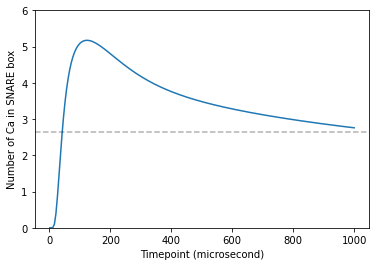

In [13]:
# CODE FOR ANALYTICAL SOLUTION PLOTTING
ca_s = np.array(ca_s)
ca_s[ca_s < 0] = 0
plt.plot(timepoints, ca_s)
plt.axhline(2.6375, color='k', linestyle='--', alpha=0.3)
#plt.yscale('log')
plt.ylim([0,6])
plt.xlabel("Timepoint (microsecond)")
plt.ylabel("Number of Ca in SNARE box")
plt.show()

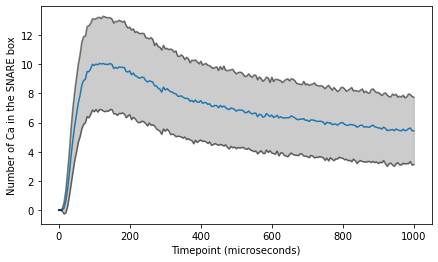

In [26]:
# CODE FOR MCELL PLOTTING
timepts_int = [int(tp) for tp in sampled_timepts]

plt.figure(figsize=(7, 4))
plt.fill_between(timepts_int, np.array(n_ca_all_mean) - np.array(n_ca_all_std), np.array(n_ca_all_mean) + np.array(n_ca_all_std),
                alpha = 0.2, color = 'k')
plt.plot(timepts_int, n_ca_all_mean)
plt.plot(timepts_int, np.array(n_ca_all_mean) + np.array(n_ca_all_std), color = 'k', alpha = 0.5)
plt.plot(timepts_int, np.array(n_ca_all_mean) - np.array(n_ca_all_std), color = 'k', alpha = 0.5)
plt.xlabel("Timepoint (microseconds)")
plt.ylabel("Number of Ca in the SNARE box")
plt.savefig('ca_diff_mcell_output_num.png')
plt.show()

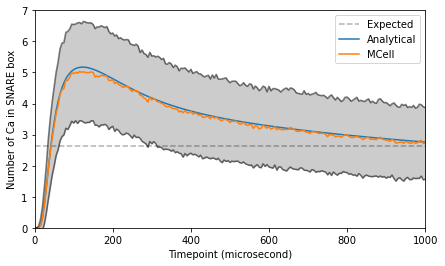

In [38]:
# COMPARE OUTPUT 
plt.figure(figsize=(7, 4))

# EXPECTED LONG TERM BEHAVIOR
plt.axhline(2.6375, color='k', linestyle='--', alpha=0.3)

# ANALYTICAL SOLUTION PLOTTING
ca_s = np.array(ca_s)
ca_s[ca_s < 0] = 0
plt.plot(timepoints, ca_s)

# MCELL PLOTTING
timepts_int = [int(tp) for tp in sampled_timepts]
plt.fill_between(timepts_int, (np.array(n_ca_all_mean) - np.array(n_ca_all_std))/2, (np.array(n_ca_all_mean) + np.array(n_ca_all_std))/2,
                alpha = 0.2, color = 'k')
plt.plot(timepts_int, np.array(n_ca_all_mean)/2)
plt.plot(timepts_int, (np.array(n_ca_all_mean) + np.array(n_ca_all_std))/2, color = 'k', alpha = 0.5)
plt.plot(timepts_int, (np.array(n_ca_all_mean) - np.array(n_ca_all_std))/2, color = 'k', alpha = 0.5)


# MAKE PLOT PRETTY
plt.legend(["Expected", "Analytical", "MCell"])
plt.ylim([0,7])
plt.xlim([0, 1000])
plt.xlabel("Timepoint (microsecond)")
plt.ylabel("Number of Ca in SNARE box")
plt.savefig('ca_diff_output.png')
plt.show()